In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections #for counter()
import seaborn as sns
import matplotlib.pyplot as plt



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train.csv
/kaggle/input/gender_submission.csv
/kaggle/input/test.csv


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import KFold


In [3]:
train=pd.read_csv('/kaggle/input/train.csv')
test=pd.read_csv('/kaggle/input/test.csv')


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = collections.Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   


# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [6]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [7]:
train=train.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

In [8]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
dataset=dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [11]:
sns.set(style="white",palette="deep",context="notebook")

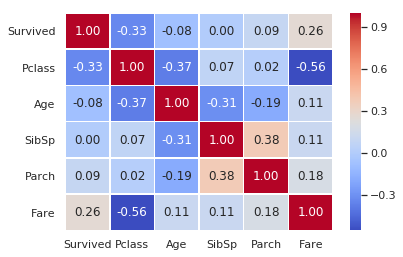

In [12]:
#heatmap
g=sns.heatmap(train[['Survived','Pclass','Age','SibSp','Parch','Fare']].corr(),annot=True,fmt="0.2f",cmap="coolwarm",linewidth=0.4)

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


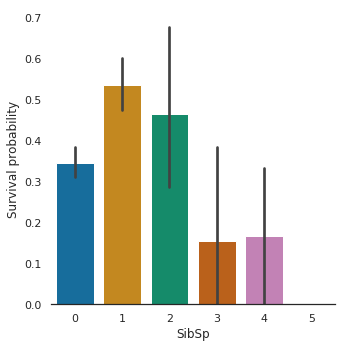

In [13]:
g=sns.factorplot(data=train,x="SibSp",y="Survived",palette="colorblind",kind="bar")
g.despine(left=True)
g=g.set_ylabels("Survival probability")

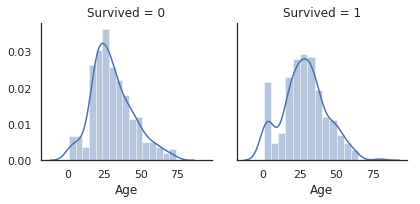

In [14]:
# Explore Age feature vs Survived
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

In [15]:
dataset[dataset['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1033,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [16]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

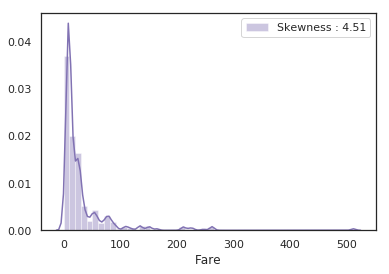

In [17]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [18]:
dataset['Fare']=dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

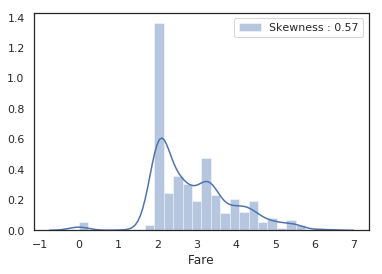

In [19]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

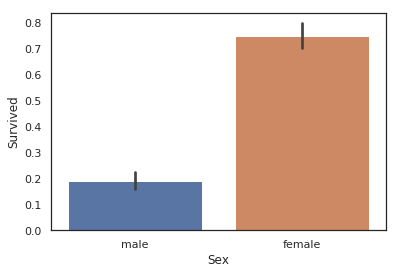

In [20]:
g=sns.barplot(data=train,x='Sex',y='Survived')


In [21]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


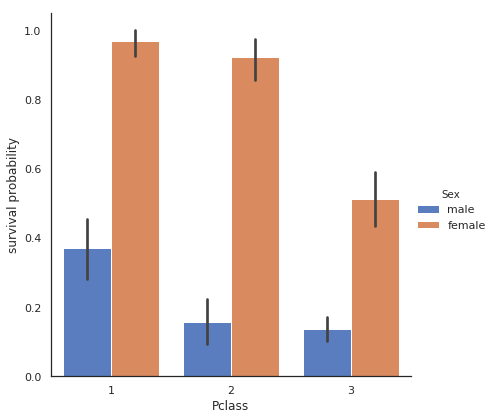

In [22]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=train,kind="bar", size = 6 , 
palette = "muted")
#g.despine(left=True)
g = g.set_ylabels("survival probability")

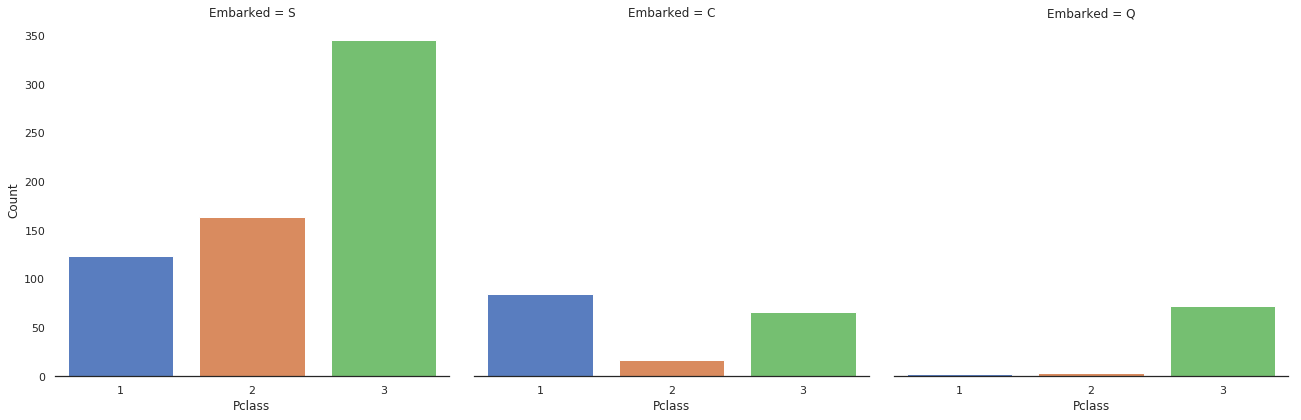

In [23]:
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

In [24]:
dataset["Embarked"]=dataset['Embarked'].fillna("S")

In [25]:
dataset['Embarked'].isnull().sum()

0

In [26]:
dataset['Sex']=dataset['Sex'].map(lambda i: 0 if i=='male'else 1)

In [27]:
dataset['Sex']

0       0
1       1
2       1
3       1
4       0
5       0
6       0
7       0
8       1
9       1
10      1
11      1
12      0
13      0
14      1
15      1
16      0
17      0
18      1
19      1
20      0
21      0
22      1
23      0
24      1
25      1
26      0
27      1
28      0
29      0
       ..
1269    0
1270    0
1271    0
1272    1
1273    0
1274    0
1275    0
1276    1
1277    0
1278    1
1279    0
1280    0
1281    1
1282    0
1283    1
1284    0
1285    0
1286    0
1287    0
1288    0
1289    1
1290    1
1291    1
1292    1
1293    1
1294    0
1295    1
1296    0
1297    0
1298    0
Name: Sex, Length: 1299, dtype: int64

In [28]:
dataset['Age']=dataset['Age'].fillna(np.nan)

In [29]:
dataset['Age'].isnull().sum()

256

In [30]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


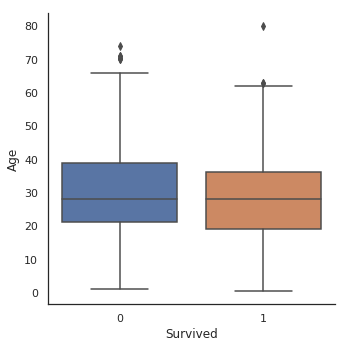

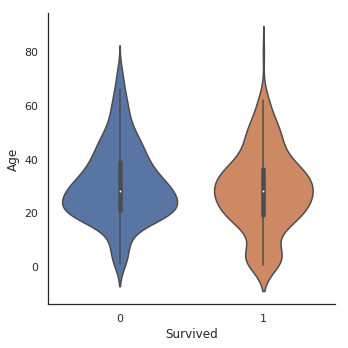

In [31]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")
      

In [32]:
dataset.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [33]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.DataFrame(dataset_title)
dataset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr
5,25.0,NaN,Q,2.135148,"Moran, Mr. James",0,6,3,0,0,0.0,330877,Mr
6,54.0,E46,S,3.948596,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,Mr
7,2.0,NaN,S,3.048088,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,349909,Master
8,27.0,NaN,S,2.409941,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,347742,Mrs
9,14.0,NaN,C,3.403555,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,237736,Mrs


In [34]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr
5,25.0,NaN,Q,2.135148,"Moran, Mr. James",0,6,3,0,0,0.0,330877,Mr
6,54.0,E46,S,3.948596,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,Mr
7,2.0,NaN,S,3.048088,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,349909,Master
8,27.0,NaN,S,2.409941,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,347742,Mrs
9,14.0,NaN,C,3.403555,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,237736,Mrs


In [35]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,1
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,1
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,2
5,25.0,NaN,Q,2.135148,"Moran, Mr. James",0,6,3,0,0,0.0,330877,2
6,54.0,E46,S,3.948596,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,2
7,2.0,NaN,S,3.048088,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,349909,0
8,27.0,NaN,S,2.409941,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,347742,1
9,14.0,NaN,C,3.403555,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,237736,1


In [36]:
dataset.Title

0       2
1       1
2       1
3       1
4       2
5       2
6       2
7       0
8       1
9       1
10      1
11      1
12      2
13      2
14      1
15      1
16      0
17      2
18      1
19      1
20      2
21      2
22      1
23      2
24      1
25      1
26      2
27      1
28      2
29      3
       ..
1269    2
1270    0
1271    2
1272    1
1273    0
1274    2
1275    2
1276    1
1277    2
1278    1
1279    2
1280    2
1281    1
1282    2
1283    1
1284    2
1285    2
1286    2
1287    2
1288    2
1289    1
1290    1
1291    1
1292    1
1293    1
1294    2
1295    3
1296    2
1297    2
1298    0
Name: Title, Length: 1299, dtype: int64

In [37]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)


In [38]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2,2
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1,2
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1,2
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2,1


In [39]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2,2,0,1,0,0
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1,2,0,1,0,0
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1,1,0,0,0
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1,2,0,1,0,0
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2,1,1,0,0,0


In [40]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


In [41]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"] ])
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,0,1,0.0,A/5 21171,2,...,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC 17599,2,...,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,...,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,113803,2,...,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,373450,1,...,1,0,0,0,0,0,0,0,0,1


In [42]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [43]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")


In [44]:
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,1,3,0,1,0.0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [45]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")
# Drop useless variables 
IDtest = test["PassengerId"]

dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [46]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [47]:
train.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [48]:
## Separate train features and label 


Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

In [49]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [50]:
X_train.head()

,Age,Fare,Parch,Sex,SibSp,Fsize,Single,SmallF,MedF,LargeF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,2,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


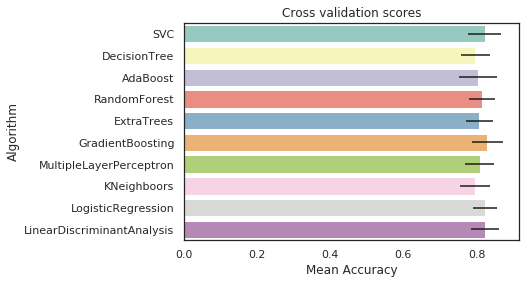

In [51]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [52]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 620 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.5s finished


In [53]:
gsadaDTC.best_score_


0.8240635641316686

In [54]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   52.2s finished


0.8320090805902384

In [55]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   57.3s finished


0.8331441543700341

In [56]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   38.3s finished


0.8286038592508513

In [57]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   39.9s finished


0.8331441543700341

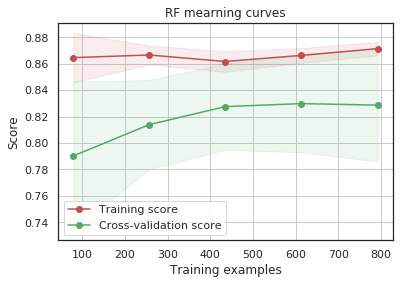

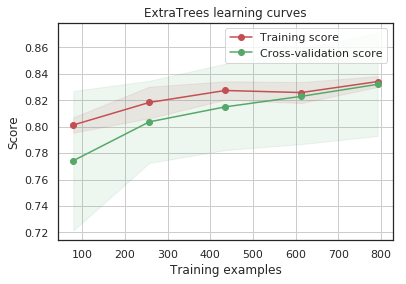

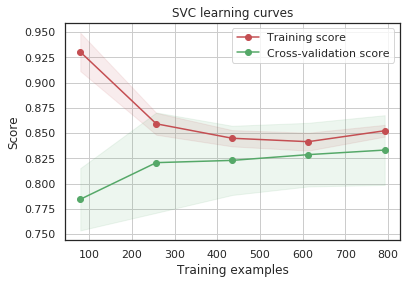

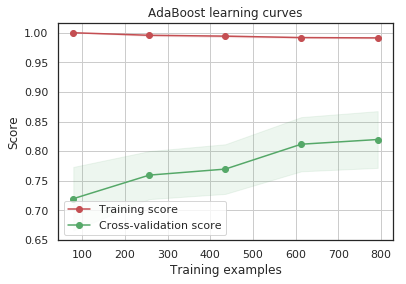

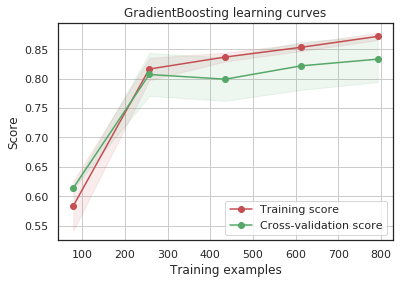

In [58]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

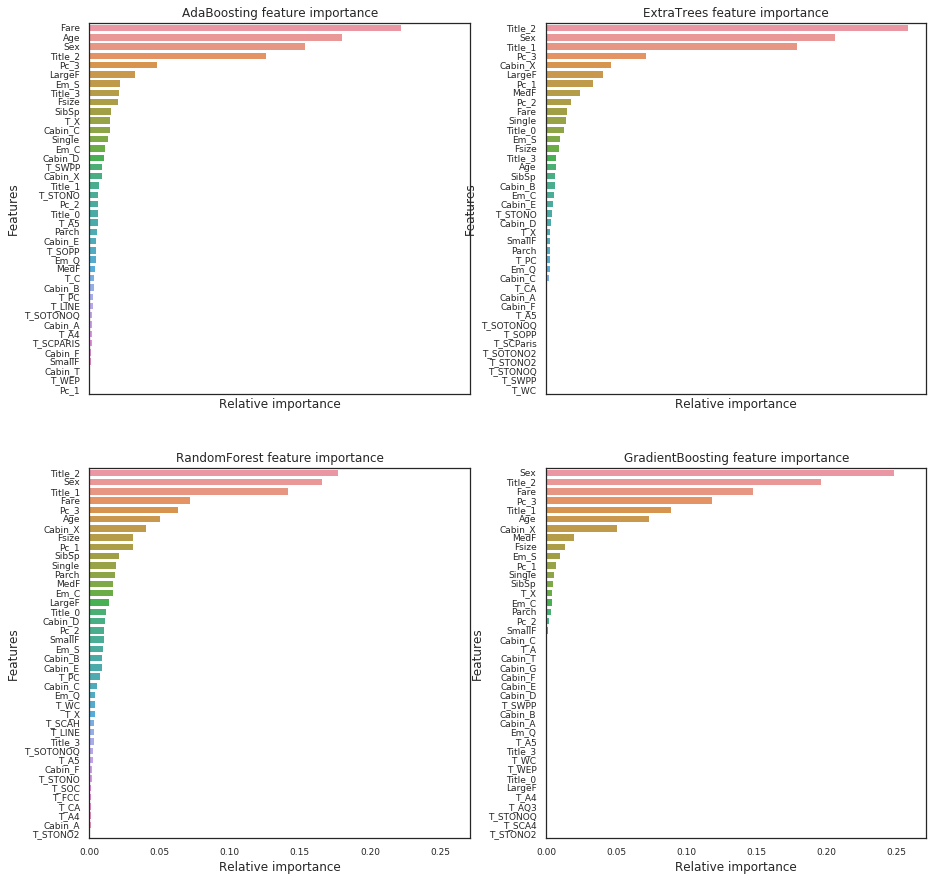

In [59]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

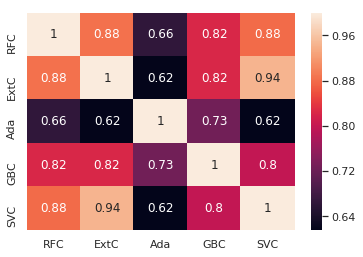

In [60]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [61]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [62]:
test_Survived = pd.Series(votingC.predict(test).astype(int), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)